# Import Library and Dataset

In [1]:
!pip install tensorflow # Installs TensorFlow library
!pip install keras # Installs keras library
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=e530177c5f76c7b97d7a1e03dd720e53854ff00775585e2fe1efb74c995f2e66
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [2]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os
from datetime import datetime

%matplotlib inline

# Prepare Data

In [3]:
train_path = "/content/drive/MyDrive/plant_disease/dataset/Train"
test_path = "/content/drive/MyDrive/plant_disease/dataset/Test"
valid_path = "/content/drive/MyDrive/plant_disease/dataset/Validation"

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CLASS_SIZE = 3

In [5]:
train_datagen = ImageDataGenerator(rescale=0)
train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=0)
test_generator = test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=0)
valid_generator = valid_datagen.flow_from_directory(
        directory=valid_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [6]:
class_names = train_generator.class_indices
class_names

{'Healthy plants': 0,
 'Plants with powdery disease': 1,
 'Plants with rust disease': 2}

# Create Model

In [7]:
import random
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [8]:
data_augmentation = keras.Sequential([preprocessing.RandomRotation(0.0)], name ="data_augmentation")

In [9]:
base_model = keras.applications.MobileNetV3Small(input_shape=(224, 224, 3),include_top=False, weights='imagenet') # Load the MobileNetV3Small model
base_model.trainable = True # Enable to train Pre-Trained Model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # Define input layer

4334752/4334752 [==============================] - 0s 0us/step


In [10]:
x = data_augmentation(inputs) # Apply Augmentation to the input images. this use for decrease overfit
x = base_model(x, training=False) # Pass Augmentation Data to base_model
x = layers.GlobalAveragePooling2D(name="GloPool")(x) # Create Global Average Pooling and input x to get output tensor that value = Dense's filter. this use for decrease feature map
outputs = tf.keras.layers.Dense(CLASS_SIZE, activation="softmax", name="output_layer")(x) # output layer that (output unit = CLASS_SIZE as image class, activation function is softmax  )
model_0 = tf.keras.Model(inputs, outputs) # Create Model name model_0 that have input layer, base mosel, output layer
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"]) #Compile model_0 with categorical_crossentropy, adam's learning rate = 0.0001, metric by accuracy

In [11]:
custom_early_stopping = EarlyStopping( # EarlyStopping is keras's callback function that stop training model before overfitting
    monitor='val_loss', # monitor at validation loss
    patience=10,
    min_delta=0.001, # if validation loss is not decrease at least 0.001 in 10 time
    mode='min' # need validtion loss to decrease
)

# Train Model

In [12]:
start = datetime.now()

history = model_0.fit(train_generator, # Use from train generator
           epochs=6, # training round -> 6
           workers=0,
           steps_per_epoch=len(train_generator), # Use from batch size that can update each epoch for training
           validation_data=valid_generator, # Use from test generator
           validation_steps=len(valid_generator), # 25% of test data
           callbacks=[custom_early_stopping]) # Stop training when overfitting
          #  callbacks = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

print ('Execution Time: ',datetime.now()-start)

Epoch 1/6
42/42 [==============================] - 494s 11s/step - loss: 0.4481 - accuracy: 0.8411 - val_loss: 0.0862 - val_accuracy: 0.9667
Epoch 2/6
42/42 [==============================] - 185s 4s/step - loss: 0.0410 - accuracy: 0.9871 - val_loss: 0.0533 - val_accuracy: 0.9667
Epoch 3/6
42/42 [==============================] - 185s 4s/step - loss: 0.0199 - accuracy: 0.9947 - val_loss: 0.1078 - val_accuracy: 0.9667
Epoch 4/6
42/42 [==============================] - 198s 5s/step - loss: 0.0121 - accuracy: 0.9955 - val_loss: 0.0481 - val_accuracy: 0.9667
Epoch 5/6
42/42 [==============================] - 187s 4s/step - loss: 0.0067 - accuracy: 0.9985 - val_loss: 0.0160 - val_accuracy: 0.9833
Epoch 6/6
42/42 [==============================] - 185s 4s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9833
Execution Time:  0:24:56.022448


In [13]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, None   0         
 ial)                        )                                   
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 GloPool (GlobalAveragePool  (None, 576)               0         
 ing2D)                                                          
                                                                 
 output_layer (Dense)        (None, 3)                 1731      
                                                             

In [14]:
# Evaluate the model on the test set

test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

<ipython-input-14-6717daddbeb4>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))


Test loss: 0.1424935907125473
Test accuracy: 0.9733333587646484


5/5 [==============================] - 15s 3s/step


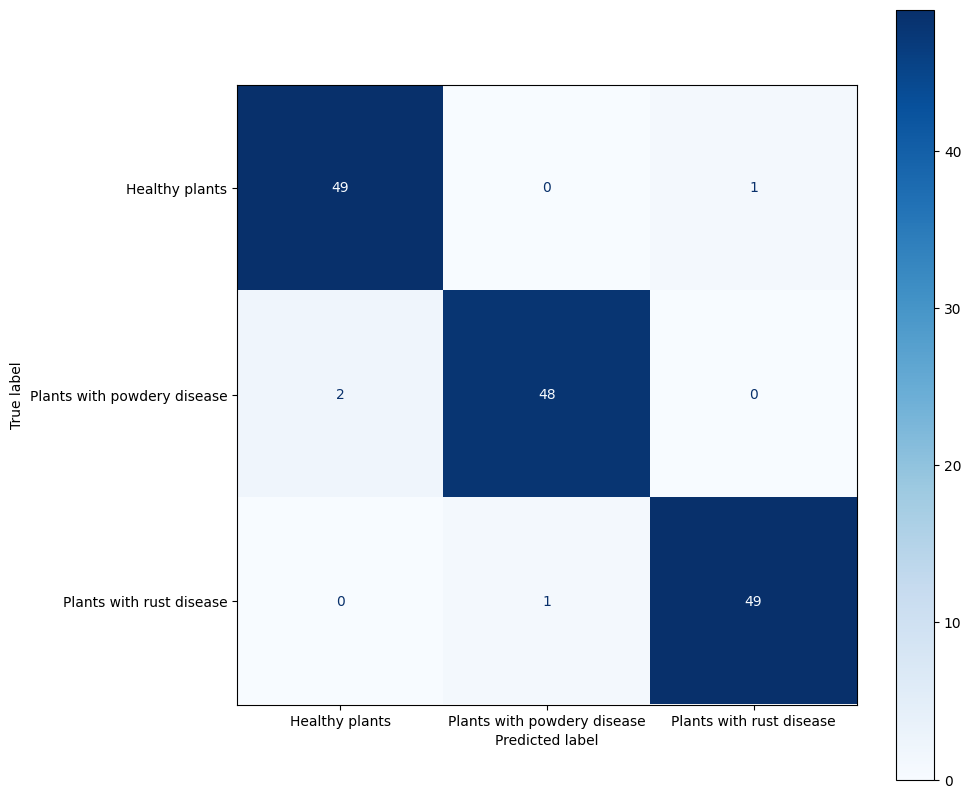

,class,specificity,sensitivity
0,0,0.98,0.98
1,1,0.99,0.96
2,2,0.99,0.98


In [15]:
import sklearn as scikit_learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

test_true=test_generator.classes[test_generator.index_array]
test_pred_raw = model_0.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()


res = []
for l in [0,1,2]:
    pres,recall,_,_ = precision_recall_fscore_support(np.array(test_true)==l,np.array(test_pred)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

In [16]:
from sklearn.metrics import classification_report


report = classification_report(test_true, test_pred,target_names=class_names)
print(report)

                             precision    recall  f1-score   support

             Healthy plants       0.96      0.98      0.97        50
Plants with powdery disease       0.98      0.96      0.97        50
   Plants with rust disease       0.98      0.98      0.98        50

                   accuracy                           0.97       150
                  macro avg       0.97      0.97      0.97       150
               weighted avg       0.97      0.97      0.97       150



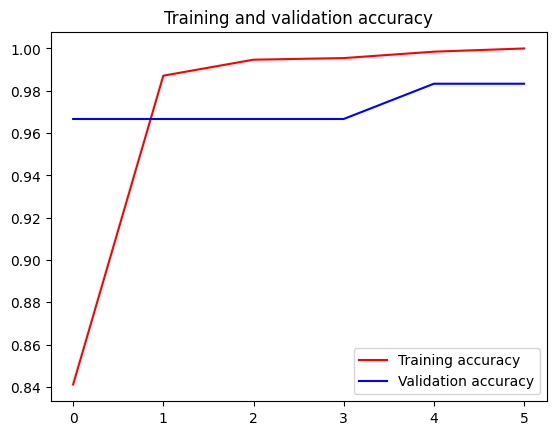

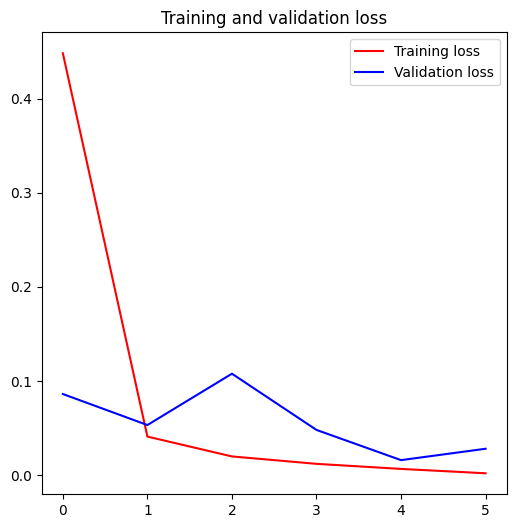

<Figure size 600x600 with 0 Axes>

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.show()

# Test with real image

In [18]:
import os

# Path to the folder containing images to predict
folder_path = '/content/drive/MyDrive/plant_disease/forTest'

In [19]:
# Loop through each image in the folder
for filename in os.listdir(folder_path):
    # Load the image
    img_path = os.path.join(folder_path, filename)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)

    # Make prediction
    prediction = model_0.predict(img_array)
    class_names = train_generator.class_indices
    class_names = {v: k for k, v in class_names.items()} # reverse the class_indices dictionary
    predicted_class = np.argmax(prediction, axis=1)
    predicted_class_name = class_names[predicted_class[0]]
    predicted_prob = np.max(prediction, axis=1)

    # Print the result
    print("Image name:", filename)
    print("Predicted class: {} ({:.2f}%)".format(predicted_class_name, predicted_prob[0]*100))
    prediction_list = prediction.tolist() # Convert the NumPy array to a Python list
    prediction_formatted = ["{:.2%}".format(p) for p in prediction_list[0]]
    print("Prediction: ", prediction_formatted)
    plt.imshow(img)
    plt.title("Predicted class: {} ({:.2f}%)".format(predicted_class_name, predicted_prob[0]*100))
    plt.show()

    # Generative ai
    import wikipedia
    if (predicted_class_name == 'Healthy plants'):
      print(wikipedia.summary('how to improve plants health'))
    elif (predicted_class_name == 'Plants with powdery disease'):
      print(wikipedia.summary('how to protect plants from powdery mildew'))
    else:
       print(wikipedia.summary('how to protect plants from rust (fungus)'))
    # print(predicted_class_name)
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

# Save and Load h5 Model

In [20]:
# Save the trained model to a .h5 file
model_0.save('/content/drive/MyDrive/plant_disease/model/newmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
from keras.models import load_model
loadmodel = load_model('/content/drive/MyDrive/plant_disease/model/newmodel.h5')